In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import umap

import matplotlib.pyplot as plt
import matplotlib
 
import pickle as pk
import h5py
import random 

# If you use the code in Github's folder VITAE instead of installing 
# via PyPI, then you need to add parent folder path to load our package
import sys; sys.path.insert(0, '..')

# Load data

Our algorithm requires at least two inputs:

- `count`$\in \mathbb{R}^{n_{\text{cell}}\ \ \times\ \ n_{\text{gene}}}$, the raw count matrix for the UMI/non-UMI model, or the preprocessed expression matrix for the Gaussian model.
- `NUM_CLUSTER`$\in \mathbb{N}^+$, the number of clusters.

One can also provides some prior information:

- `grouping`$\in \mathbb{R}^{n_{\text{cell}}}$, the true/estimated groupings
- `gene_names`$\in \mathbb{R}^{n_{\text{cell}}}$
- `cell_ids`$\in \mathbb{R}^{n_{\text{cell}}}$

We have prepare some datasets in **hdf5** format, which can be easily loaded by the following codes:

In [2]:
from VITAE import get_igraph, leidenalg_igraph, plot_clusters, load_data

file_name = 'mouse_brain_merged'
data = load_data(path='../data/',
                 file_name=file_name)

# To see the available fields of the dataset
print(data.keys())

dict_keys(['count', 'grouping', 'gene_names', 'cell_ids', 'milestone_net', 'root_milestone_id', 'covariates', 'type'])


# Preprocess data

We follows the precedure

- Remove cells without expressions.
- Remove genes without variations across samples.
- Apply log-normalization to the count data $X$ and get $X_{\text{norm}}$.
- Select influential genes based on $X$ by the method described in Page 12-13: Data preprocessing - Feature selection for individual datasets, https://www.biorxiv.org/content/biorxiv/early/2018/11/02/460147.full.pdf.
- Apply per-gene standardization to $X_{\text{norm}}$ as the input of the neural network.

For more details about the provided functions, please check out the [documents](https://jaydu1.github.io/VITAE/).

Removing 0 cells without expression.
Removing 1 genes without variability.
min normailized value: 0.0
max normailized value: 8.085677


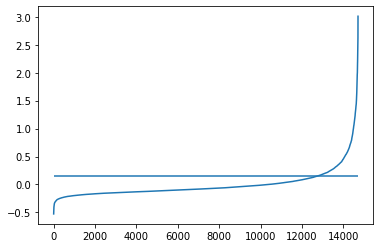

Number of cells in each class: 
0 <---> Endothelial Cell        50
1 <---> IPC                   1908
10 <---> OPC                   261
11 <---> Pericyte               25
12 <---> Pia                   142
13 <---> RGC                  3038
2 <---> Immature Neuron       2877
3 <---> Interneurons           437
4 <---> Layer I                640
5 <---> Layer II-IV           1750
6 <---> Layer V-VI            3178
7 <---> Layer V-VI (Hippo)     431
8 <---> Microglia               32
9 <---> NEC                   1882
dtype: int64


In [3]:
from VITAE import VITAE

# Clear the tf session if necessary, especially when rerunning the model. 
# tf.keras.backend.clear_session() 

# Here we set random seed to reproduce the results on the same 
# computer/machine. Note that since floating-point computation 
# may be different on different computers, the results will be 
# slightly different and the errors are accumulated during training. 
# Refer to https://github.com/tensorflow/tensorflow/issues/38197#issuecomment-637846372
# for more details about reproducibility issues of floating point computation.
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

# Using tf.float64 for training can alleviate this problem, 
# while it requires more computational resources.
tf.keras.backend.set_floatx('float64')


# create an instance
model = VITAE()

# fit in data
model.get_data(data['count'],                   # count or expression matrix, (dense or sparse) numpy array 
               labels = data['grouping'],       # (optional) labels, which will be converted to string
               covariate = data['covariates'],  # (optional) covariates
               gene_names = data['gene_names'], # (optional) gene names, which will be converted to string
               cell_names = data['cell_ids']    # (optional) cell names, which will be converted to string
              )

# preprocess data
model.preprocess_data(K = 1e4,                # (optional) denominator of the scale factor for log-normalization (the default is 1e4)
                      gene_num = 2000,        # (optional) maximum number of influential genes to keep (the default is 2000)
                      data_type = 'Gaussian',      # (optional) data_type can be 'UMI', 'non-UMI' or 'Gaussian' (the default is 'UMI')
                      npc = 64                # (optional) number of PCs to keep if data_type='Gaussian' (the default is 64)
                     )

# Build model

Now we are able to create the neural network.

In [4]:
model.build_model(dim_latent = 8,         # The size of the latent dimension
                  dimensions = [32]       # The size of each layer in the encoder between the input layer and the 
                                          # latent layer. The size of each layer in the decoder is the reverse.
                  )

# Pretrain

In the current stage, we only define the Autoencoder. The latent sturcture is still undefined. Before adding that, we'd better pretrain the Autoencoder to learn a better reprsentation $Z$ of $X$.

A large batch size will give a better and stable model, while it takes more memory to run. So if you are concerned about this, you could reduce the batch size.

In [5]:
model.pre_train(stratify = False,            # (Optional) use random (unstratified) shuffle splitting when it is 'False'. Set to 'None' to use 'model.labels'. Otherwise, an array need to be provided.
                test_size = 0.1,             # (Optional) the proportion or size of the test set.
                random_state = 0,            # (Optional) the random state of data splitting.
                learning_rate = 1e-3,        # (Optional) the initial learning rate for the Adam optimizer (the default is 1e-3).
                batch_size=256,              # (Optional) the batch size for pre-training (the default is 32). 
                L=1,                         # (Optional) the number of MC samples (the default is 1).
                alpha=0.10,                  # (Optional) the value of alpha in [0,1] to encourage covariate adjustment. Not used if there is no covariates.                
                num_epoch = 300,             # (Optional) the maximum number of epoches (the default is 300).                
                num_step_per_epoch = None,   # (Optional) the number of step per epoch, it will be inferred from number of cells and batch size if it is None (the default is None).
                early_stopping_tolerance=1.0,  # (Optional) the minimum change of loss to be considered as an improvement (the default is 1e-3).
                early_stopping_patience=5,   # (Optional) the maximum number of epoches if there is no improvement (the default is 10).
                early_stopping_warmup=0,     # (Optional) the number of warmup epoches (the default is 0).
                path_to_weights=None         # (Optional) the path of weight file to be saved; not saving weight if None (the default is None).
                ) 

Pretrain - Start of epoch 0
59/59 [==============================] - 3s 49ms/step - Reconstructed Loss: 239.7108
 Training loss over epoch: 237.3846. Testing loss over epoch: 257.6280
Pretrain - Start of epoch 1
59/59 [==============================] - 1s 17ms/step - Reconstructed Loss: 251.2348
 Training loss over epoch: 214.1770. Testing loss over epoch: 245.3700
Pretrain - Start of epoch 2
59/59 [==============================] - 1s 17ms/step - Reconstructed Loss: 191.6121
 Training loss over epoch: 192.0501. Testing loss over epoch: 212.1091
Pretrain - Start of epoch 3
59/59 [==============================] - 1s 16ms/step - Reconstructed Loss: 177.4460
 Training loss over epoch: 171.0013. Testing loss over epoch: 189.6791
Pretrain - Start of epoch 4
59/59 [==============================] - 1s 15ms/step - Reconstructed Loss: 137.1100
 Training loss over epoch: 153.8225. Testing loss over epoch: 186.8704
Pretrain - Start of epoch 5
59/59 [==============================] - 1s 15ms/ste

59/59 [==============================] - 1s 21ms/step - Reconstructed Loss: 58.8729
 Training loss over epoch: 67.0635. Testing loss over epoch: 79.6626
Pretrain - Start of epoch 46
59/59 [==============================] - 1s 22ms/step - Reconstructed Loss: 64.5950
 Training loss over epoch: 66.9067. Testing loss over epoch: 75.2109
Pretrain - Start of epoch 47
59/59 [==============================] - 1s 20ms/step - Reconstructed Loss: 79.3046
 Training loss over epoch: 66.6173. Testing loss over epoch: 76.3863
Pretrain - Start of epoch 48
59/59 [==============================] - 1s 20ms/step - Reconstructed Loss: 71.7557
 Training loss over epoch: 66.3318. Testing loss over epoch: 75.7896
Pretrain - Start of epoch 49
59/59 [==============================] - 1s 22ms/step - Reconstructed Loss: 66.9101
 Training loss over epoch: 66.4673. Testing loss over epoch: 74.9673
Pretrain - Start of epoch 50
59/59 [==============================] - 1s 18ms/step - Reconstructed Loss: 70.4584
 Train

You can also save and load model weights by uncommenting and running the following codes:

In [6]:
# save model weight
model.save_model(path_to_file='../weight/tutorial_mouse_brain_merged/mouse_brain_pre_train.checkpoint')

# load model weight, which can build or re-build the network based on wieght file 
# model.load_model(path_to_file='../weight/tutorial_mouse_brain_merged/mouse_brain_pre_train.checkpoint', 
#                                          # path to the weight file.
#                  load_labels=False       # (Optional) whether to load clustering labels or not.
#                                          # If load_labels is True, then the LatentSpace layer
#                                          # will be initialized basd on the model. 
#                                          # If load_labels is False, then the LatentSpace layer
#                                          # will not be initialized.
#                 )

# Clustering and initialize latent structure

## When prior of labeling is avialable

If you have information of the grouping/labels of cells, you are free to use them to initialze the latent structure, so that you will get better estimate and inference results, especially when the sample size is small or the classes are unbalanced.

In [7]:
# Get latent representations of X after pre-training
z = model.get_latent_z()
# z will be slightly different on different machines.
# For reproducibility purpose, truncate it.
# z = np.round(z,6)

# Assign pre-given labels to initialize the latent structure
# The object 'model.labels' is encoded as categorical data from 'model.label_names'.
labels = model.label_names    

We can plot the clusters to see how it looks like. We provide a function to do dimension reduction easily.

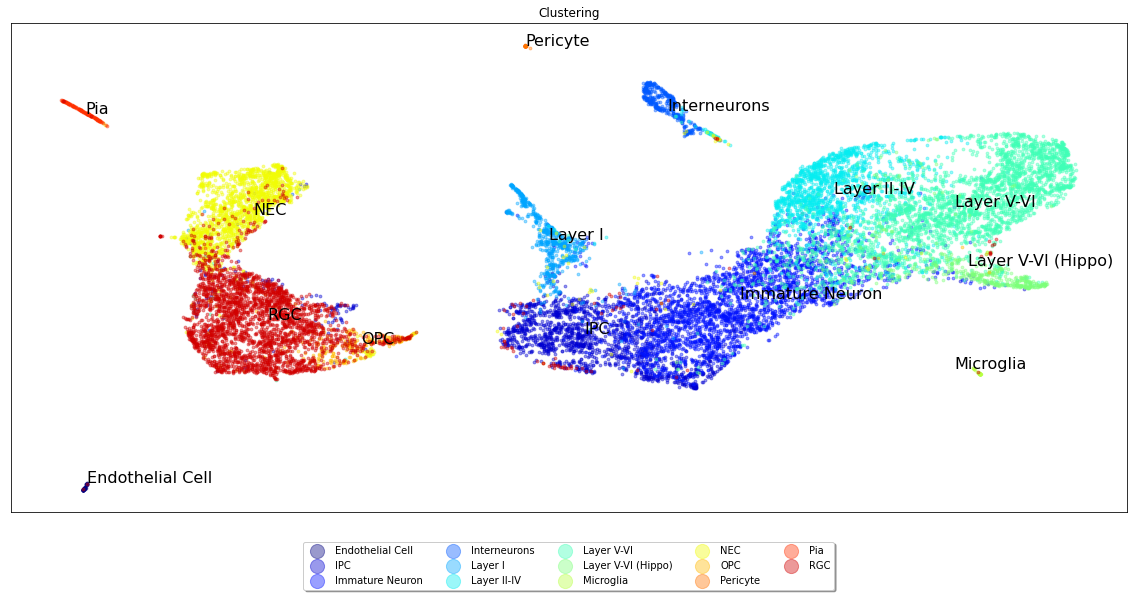

In [8]:
from VITAE import get_embedding
embed_z = get_embedding(z, 
                        dimred='umap', # 'umap', pca' and 'tsne'. Recommend to use umap for general data
                                       # as it is fast. Sometimes 'umap' will break points into separate
                                       # clusters, in such case 'tsne' is recommended while it is somehow 
                                       # slow. For simple data, 'pca' will be good enough.
                        random_state=0
                       # **kwargs, extra key-value argument for the dimension reduction algorithms
                       )      
plot_clusters(embed_z, 
              model.label_names,
              plot_labels=True)

Suppose we want to select a subset of the cells. For example, we want to remove cluster '09' (which is encoded as 4), we can do:

```
cell_subsets = model.cell_names[labels != 4]
model.set_cell_subset(cell_subsets) 
# this will update the model variables 'selected_cell_subset' & 'selected_cell_subset_id',
# corresponding to cell names & cell ids respectively.
# However, if you do not select a subset, these two variables will also be initialzed to
# be include all cells.
labels = labels[model.selected_cell_subset_id]
z = z[model.selected_cell_subset_id,:]
```

Then the later operations, such as training and inference, will automatically only deal with the selected subset of cells. 

## When prior of labeling is not available

In such case, we can first apply any clustering algorithm like Louvain to obtain clusters. With a suitble resolution parameter, we divide the cells into different regions. Then the number of clusters and the cluster centers can be used for initialzing our latent space.

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


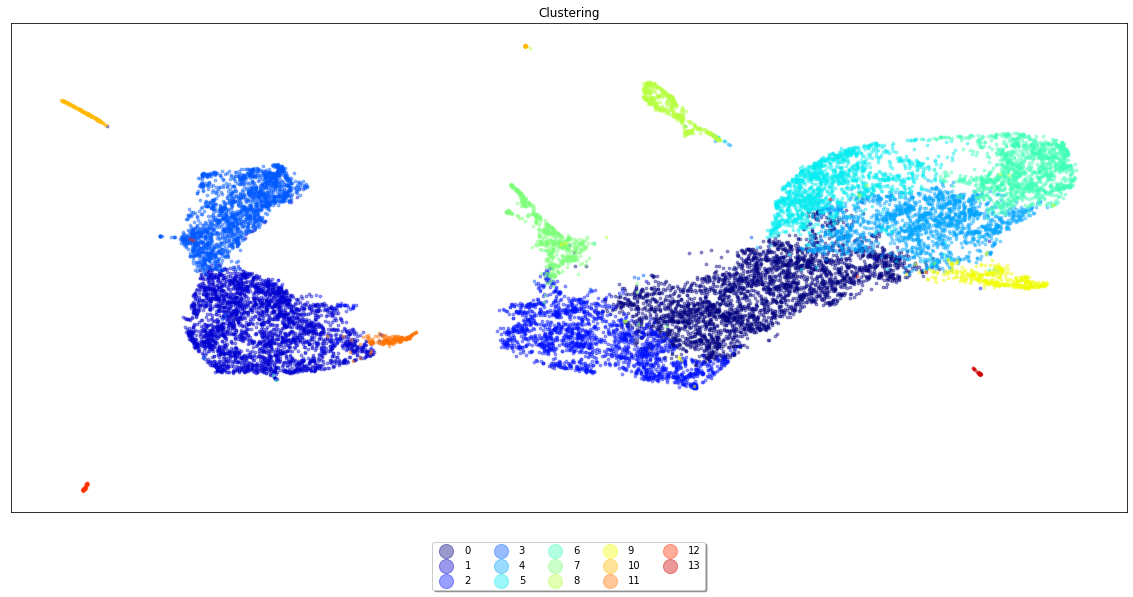

In [9]:
g = get_igraph(z, random_state=0)
# You can choose different resolution parameter to get satisfied clustering results.
# In this example, roughly 9-10 clusters on the main branch will be reasonable.
labels = leidenalg_igraph(g, 0.6, random_state=0) 
plot_clusters(embed_z, labels)
print(np.unique(labels))

## Initialize latent structure

Now we need to determine $k$, either from prior information or clustering results. And we also need to initialze $\pi$ and $\mu$. 

- $\mu$: The user can provide $\mu$, the clustering centers. If not given, $\mu$ is initialized by the mean of each cluster corrsponding to the given clustering labels in latent space. If clustering labels are not given, $\mu$ is sampled from uniform $[-1,1]$.
- $\pi$: The user can provide $\pi=(\pi_{1,1},\cdots,\pi_{1,k},\pi_{2,2},\cdots,\pi_{2,k},\cdots, \pi_{k,k})\in\mathbb{R}^{1\times K}$, the prior proportion for each node and each edge. If not given, $\pi$ is uniformly initialized. 

In [10]:
NUM_CLUSTER = len(np.unique(labels))

model.init_latent_space(
    NUM_CLUSTER,                     # numebr of clusters
    cluster_labels=labels,           # (optional) clustering labels or their names for plotting
    mu=None,                         # (optional) initial mean
    log_pi=None                      # (optional) initial pi
               )                   

And we can also use estimated cluster labels from other algorithms and softwares.

# Train

In [11]:
model.train(stratify = False,            # (Optional) use random (unstratified) shuffle splitting when it is 'False'. Set to 'None' to use 'model.labels'. Otherwise, an array need to be provided.
            test_size = 0.1,             # (Optional) the proportion or size of the test set.
            random_state = 0,            # (Optional) the random state of data splitting.
            learning_rate = 1e-3,        # (Optional) the initial learning rate for the Adam optimizer (the default is 1e-3).
            batch_size=256,              # (Optional) the batch size for pre-training (the default is 32). 
            L=1,                         # (Optional) the number of MC samples (the default is 1).
            alpha=0.10,                  # (Optional) the value of alpha in [0,1] to encourage covariate adjustment. Not used if there is no covariates.
            beta=2,                      # (Optional) the value of beta in beta-VAE.
            num_epoch = 300,             # (Optional) the maximum number of epoches (the default is 300).                
            num_step_per_epoch = None,   # (Optional) the number of step per epoch, it will be inferred from number of cells and batch size if it is None (the default is None).
            early_stopping_tolerance=1,  # (Optional) the minimum change of loss to be considered as an improvement (the default is 1e-3).
            early_stopping_patience=5,   # (Optional) the maximum number of epoches if there is no improvement (the default is 10).
            early_stopping_warmup=10,    # (Optional) the number of warmup epoches (the default is 0).
            path_to_weights=None,        # (Optional) the path of weight file to be saved; not saving weight if None (the default is None). 
            plot_every_num_epoch=None,   # (Optional) plot the intermediate result every few epoches, or not plotting if it is None.            
            dimred='umap'                # (Optional) the name of dimension reduction algorithms, can be 'umap', 'pca' and 'tsne'. Default is 'umap'. Only used if 'plot_every_num_epoch' is not None. 
            #**kwargs                    # (Optional ) extra key-value arguments for calling the dimension reduction algorithms.   
            )

Warmup:10
Start of epoch 0
59/59 [==============================] - 3s 55ms/step - loss_neg_E_nb: 66.0881 - loss_neg_E_pz: 17.4502 - loss_E_qzx   : -3.9508 - loss_total: 13.4994
 Training loss over epoch: 13.5659 (65.4331, 17.5167, -3.9508) Testing loss over epoch: 100.4397 (74.4412, 16.9500, -3.9508)
Start of epoch 1
59/59 [==============================] - 2s 32ms/step - loss_neg_E_nb: 77.6805 - loss_neg_E_pz: 17.1895 - loss_E_qzx   : -3.9508 - loss_total: 13.2387
 Training loss over epoch: 13.4238 (65.7420, 17.3746, -3.9508) Testing loss over epoch: 103.1828 (76.9112, 17.0866, -3.9508)
Start of epoch 2
59/59 [==============================] - 2s 32ms/step - loss_neg_E_nb: 65.6601 - loss_neg_E_pz: 17.5859 - loss_E_qzx   : -3.9508 - loss_total: 13.6351
 Training loss over epoch: 13.2804 (65.3243, 17.2312, -3.9508) Testing loss over epoch: 98.6864 (73.2585, 16.6647, -3.9508)
Start of epoch 3
59/59 [==============================] - 2s 38ms/step - loss_neg_E_nb: 64.0512 - loss_neg_E_pz:

59/59 [==============================] - 2s 42ms/step - loss_neg_E_nb: 62.1859 - loss_neg_E_pz: 13.2946 - loss_E_qzx   : -9.2132 - loss_total: 70.3487
 Training loss over epoch: 74.7770 (66.7053, 13.2390, -9.2031) Testing loss over epoch: 81.1311 (72.9148, 13.3784, -9.2702)
Start of epoch 29
59/59 [==============================] - 2s 41ms/step - loss_neg_E_nb: 67.3262 - loss_neg_E_pz: 13.1682 - loss_E_qzx   : -9.3412 - loss_total: 74.9803
 Training loss over epoch: 74.6652 (66.7659, 13.2814, -9.3318) Testing loss over epoch: 82.4914 (74.6764, 13.3026, -9.3951)
Start of epoch 30
59/59 [==============================] - 2s 40ms/step - loss_neg_E_nb: 63.1691 - loss_neg_E_pz: 13.3565 - loss_E_qzx   : -9.4621 - loss_total: 70.9580
 Training loss over epoch: 74.5602 (66.8536, 13.3067, -9.4534) Testing loss over epoch: 81.1431 (73.4050, 13.3803, -9.5112)
Start of epoch 31
59/59 [==============================] - 3s 44ms/step - loss_neg_E_nb: 67.1531 - loss_neg_E_pz: 13.4720 - loss_E_qzx   : 

In [12]:
# save model weight with parameters in the latent space
model.save_model(path_to_file='../weight/tutorial_mouse_brain_merged/mouse_brain_train.checkpoint')

# load model weight
# model.load_model(path_to_file='../weight/tutorial_mouse_brain_merged/mouse_brain_train.checkpoint', # path to the weight file.
#                  load_labels=True
#                 )

# Inference

## Trajectory and Pseudotime

In [13]:
# initialze inference
model.init_inference(batch_size=64, 
                     L=150,            # L is the number of MC samples
                     dimred='umap',    # dimension reduction methods
                     #**kwargs         # extra key-value arguments for dimension reduction algorithms.    
                     random_state=0
                    ) 
# after initialization, we can access some variables by model.pc_x, model.w, model.w_tilde, etc..

In [14]:
# save model weight with parameters in the latent space and inference results (embedding, posterior estimations)
model.save_model(path_to_file='../weight/tutorial_mouse_brain_merged/mouse_brain_inference.checkpoint')

# load model weight
# model.load_model(path_to_file='../weight/tutorial_mouse_brain_merged/mouse_brain_inference.checkpoint', # path to the weight file.
#                  load_labels=True
#                 )

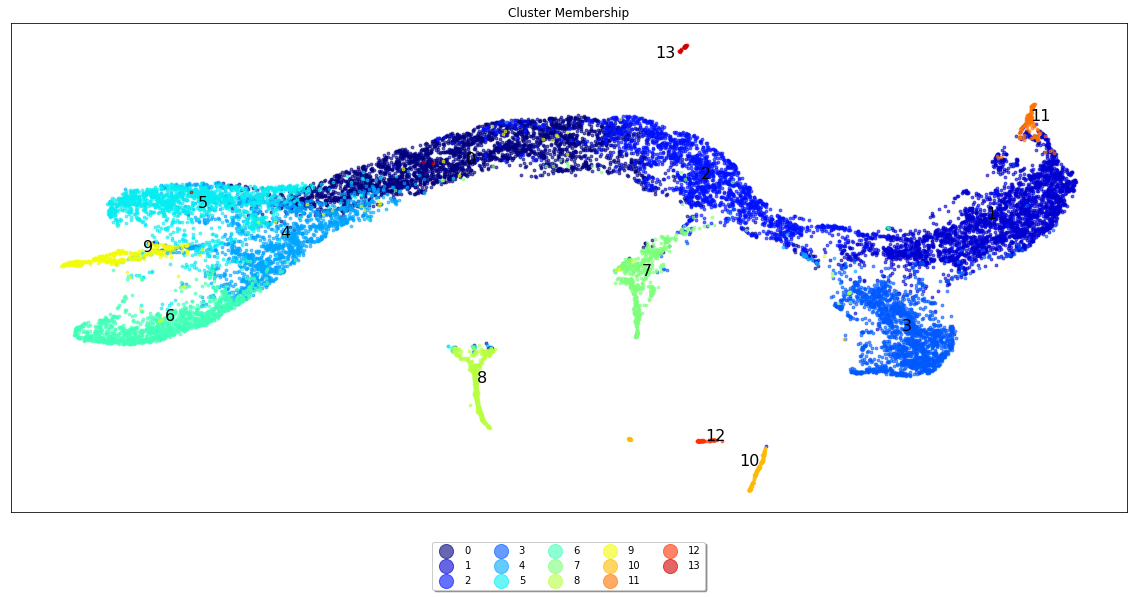

[[0.   0.   0.4  0.   0.74 0.   0.   0.14 0.   0.09 0.   0.   0.   0.  ]
 [0.   0.   0.26 0.32 0.   0.   0.   0.   0.   0.   0.   0.09 0.   0.  ]
 [0.4  0.26 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.32 0.   0.   0.   0.   0.   0.   0.   0.   0.07 0.   0.   0.  ]
 [0.74 0.   0.   0.   0.   0.4  0.5  0.   0.05 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.4  0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.14 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.05 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.09 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.07 0.   0.   0.   0.   0.   0.   0.   0.   0.11 0.  ]
 [0.   0.09 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.03]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.11 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  

In [15]:
import networkx as nx
# compute inference score, and get umap embedding
# a plot of clustering result will be displayed
G = model.comp_inference_score(method='modified_map',  # 'mean', 'modified_mean', 'map', and 'modified_map'
                               thres=0.5,              # (Optional) threshold for compute the conditional probablity, only applies to 'mean' and 'modified_mean'
                               no_loop=True            # (Optional) if no_loop=True, then find the maximum spanning tree
                               )           
# returned G is the score graph
print(np.round(nx.to_numpy_matrix(G), 2))
print(G.edges)

Now, the user needs to provide the initial node for the trajectory.

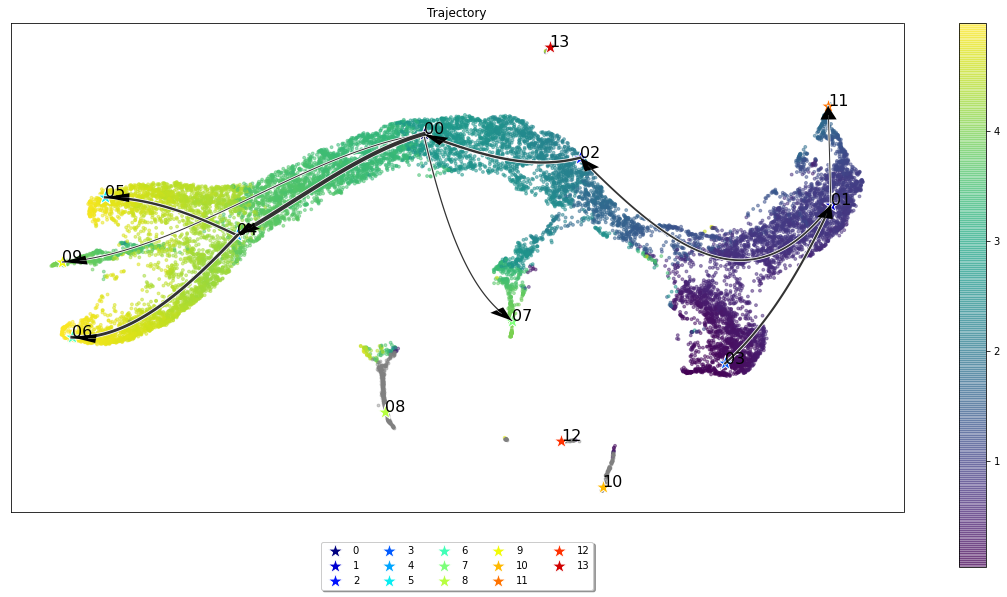

In [16]:
# Here we identify the 'begin_node_pred' as the one having maximal number of cells 
# from the earlest embryonic day.
days = np.array([i[1:3] for i in data['cell_ids']], dtype=np.float32)
begin_node_pred = model.select_root(days, 'sum')
modified_G, modified_w, pseudotime = model.infer_trajectory(
    init_node=begin_node_pred,  # initial node for computing pseudotime.
    cutoff=0.08                 # (Optional) cutoff score for edges (the default is 0.01).
    )  

## Marker Genes

In [17]:
model.selected_gene_names
# model.gene_names

array(['Hba.a1', 'H19', 'Igfbp7', ..., 'Mef2a', 'Rnd2', 'Ranbp2'],
      dtype='<U15')

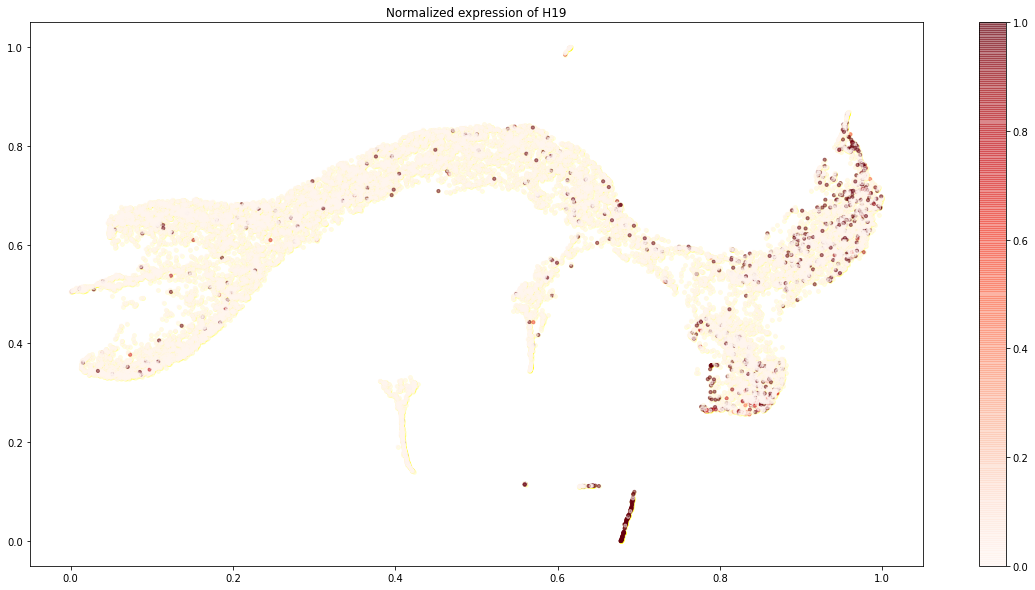

In [18]:
model.plot_marker_gene('H19')

We can select the branch 1-0-6-3 of the inferred trajectory and test for differential expressed genes.

In [19]:
id_branch = ((modified_w[:,1] > 0.0)&(modified_w[:,2] > 0.0)) | \
    ((modified_w[:,2] > 0.0)&(modified_w[:,0] > 0.0)) | \
    ((modified_w[:,0] > 0.0)&(modified_w[:,4] > 0.0))

model.set_cell_subset(
    model.cell_names[id_branch]
    )

res_df = model.differentially_expressed_test(alpha=0.05)
res_df.head()

,beta_PDT,p_adjusted
Lhx9,-0.109513,0.000003
Gm10275,-0.066535,0.020620
Zdbf2,-0.080718,0.009434
Efr3b,0.069616,0.016398
Prkar1a,-0.067206,0.025101
